In [36]:
# %pip install pyyaml opencv-python matplotlib numpy scipy -i https://pypi.tuna.tsinghua.edu.cn/simple

# 模板处理

In [37]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import yaml
import os

## 参数读入

In [38]:
source_path = 'source/1.3'
config_file_path = os.path.join(source_path, 'config.yaml')


In [39]:

def load_specific_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)

    # 提取特定配置项
    image_path = config.get('image', {}).get('path')
    candidate_points = config.get('candidate_points', [])
    zone_point = config.get('scan_zone', {}).get('center_point', [0, 0])
    zone_radius = config.get('scan_zone', {}).get('radius', 0)
    zone_theta = config.get('scan_zone', {}).get('angle', 0)
    valid_threshold = config.get('scan_zone', {}).get('valid_threshold', 0)
    step = config.get('scale', {}).get('step', 5)
    start_point = config.get('scale', {}).get('start', 0.0)
    end_point = config.get('scale', {}).get('end', 0.0)
    precision = config.get('scale', {}).get('precision', 0)
    unit = config.get('scale', {}).get('unit', '')

    return (
        image_path,
        candidate_points,
        zone_point,
        zone_radius,
        zone_theta,
        valid_threshold,
        step,
        start_point,
        end_point,
        precision,
        unit
    )

(
    image_path,
    candidate_point,
    zone_point,
    zone_radius,
    zone_theta,
    valid_threshold,
    step,
    START_POINT,
    END_POINT,
    PRESICISION,
    UNIT
) = load_specific_config(config_file_path)

# 打印提取的配置项以检查是否正确加载
print(f"Image Path: {image_path}")
print(f"Candidate Points: {candidate_point}\n")
print(f"Zone Point: {zone_point}")
print(f"Zone Radius: {zone_radius}")
print(f"Zone Theta: {zone_theta}")
print(f"Valid Threshold: {valid_threshold}")
print(f"step {step}")
print(f"Start Point: {START_POINT}\nEnd Point: {END_POINT}")
print(f"Precision: {PRESICISION}\nUnit: {UNIT}")

Image Path: source/1.3/template.jpg
Candidate Points: [[121, 551], [77, 441], [86, 292], [161, 167], [284, 88], [427, 72], [561, 121], [659, 224], [701, 360], [675, 502], [588, 620]]

Zone Point: [227, 288]
Zone Radius: 20
Zone Theta: 15
Valid Threshold: 70
step 5
Start Point: 9
End Point: 25
Precision: 2
Unit: MPa


debug用的函数

In [40]:
# 展示图片
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(8, 8))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

# 绘制点集在图片上 （reversed控制图片坐标系或真实坐标系）
def show_point(image, x_point, y_point, color = (0, 255, 255), reversed=True):
    image_temp = image.copy()
    for (x, y) in zip(x_point, y_point):
        if reversed: cv2.circle(image_temp, (int(x), int(image.shape[1] - y)), 4, color, -1)
        else: cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)

模板图片需要尽量正面

如果质量不好，建议直接将非表盘必要的内容进行屏蔽（PhotoShop）操作一下

In [41]:
# 模板读取
image = cv2.imread(image_path)
candidate_point = np.array(candidate_point)

(745, 764, 3)


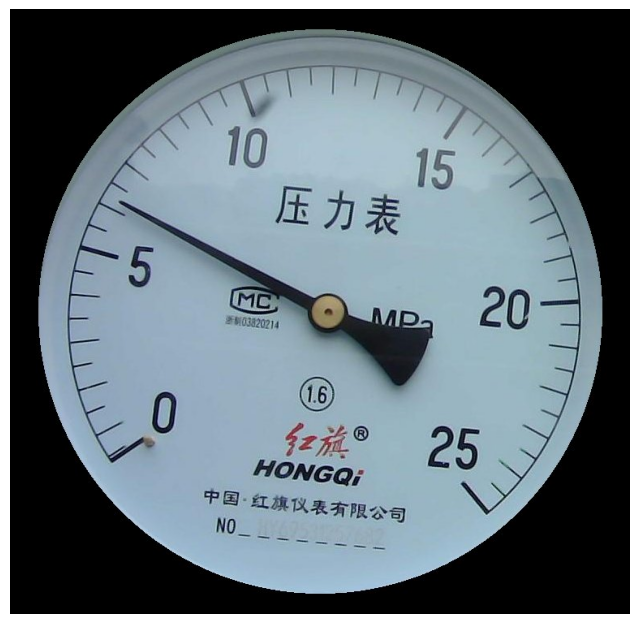

In [42]:
# debug
print(image.shape)
show_img(image)

## 椭圆拟合

In [43]:
# 拟合函数：点到椭圆两焦点距离之和
def my_fun(parameters, x_samples, y_samples):
    # Unpack parameters: two focus points and the target distance sum
    x_focus_1, y_focus_1, x_focus_2, y_focus_2, sum_of_target_distance = parameters

    # Calculate the actual distances from the points to the two foci
    sum_of_actual_distance = (
        np.sqrt((x_samples - x_focus_1) ** 2 + (y_samples - y_focus_1) ** 2) +
        np.sqrt((x_samples - x_focus_2) ** 2 + (y_samples - y_focus_2) ** 2)
    )

    # Return the variance of the difference between actual and target distances
    return np.sum((sum_of_actual_distance - sum_of_target_distance) ** 2)

# scipy 优化方法拟合
def fit_ellipse(x_samples, y_samples):

    # Optimize to fit the ellipse using initial guesses for the parameters
    initial_guess = np.array([np.mean(x_samples), np.mean(y_samples), np.mean(x_samples), np.mean(y_samples), 100])  # Initial focus points and target distance
    res_optimized = least_squares(fun=my_fun, x0=initial_guess, args=(x_samples, y_samples))

    # 拟合结束后 通过焦点坐标得到 半长短轴、椭圆中心、长轴与x轴正半轴夹角
    if res_optimized.success:
        # Unpack optimized parameters
        x1_res, y1_res, x2_res, y2_res, l2_res = res_optimized.x

        # Calculate the angle of the ellipse based on the foci
        alpha_res = np.arctan2(y2_res - y1_res, x2_res - x1_res)

        # Calculate the distance between the foci
        l_ab = np.sqrt((y2_res - y1_res) ** 2 + (x2_res - x1_res) ** 2)

        # Calculate semi-major and semi-minor axes
        a_res = l2_res / 2  # Semi-major axis length
        b_res = np.sqrt((l2_res / 2) ** 2 - (l_ab / 2) ** 2)  # Semi-minor axis length


        return a_res, b_res, (x1_res+x2_res)/2, (y1_res+y2_res)/2, alpha_res
    else:

        print('Fail to fit ellipse')
        return None



# 根据theta求解对应的椭圆点坐标
def get_Point_in_ellipse(h, k, a, b, alpha, theta):
    # 椭圆参数化方程
    x = a * np.cos(theta)
    y = b * np.sin(theta)

    # 应用旋转矩阵
    x_rot = h + x * np.cos(alpha) - y * np.sin(alpha)
    y_rot = k + x * np.sin(alpha) + y * np.cos(alpha)

    return x_rot, y_rot

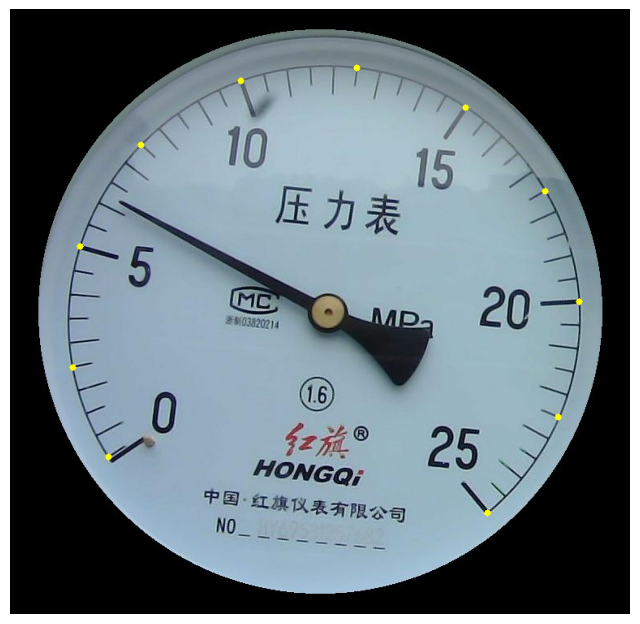

In [44]:
# 拟合过程前转换为直角坐标系（图像坐标系下的y是反的）
x_samples = candidate_point.T[0]
y_samples = image.shape[1] - candidate_point.T[1]
show_point(image, x_samples, y_samples)

In [45]:
# 求解a_res, b_res, x0, y0, alpha_res
a_res, b_res, x0, y0, alpha_res = fit_ellipse(x_samples, y_samples)

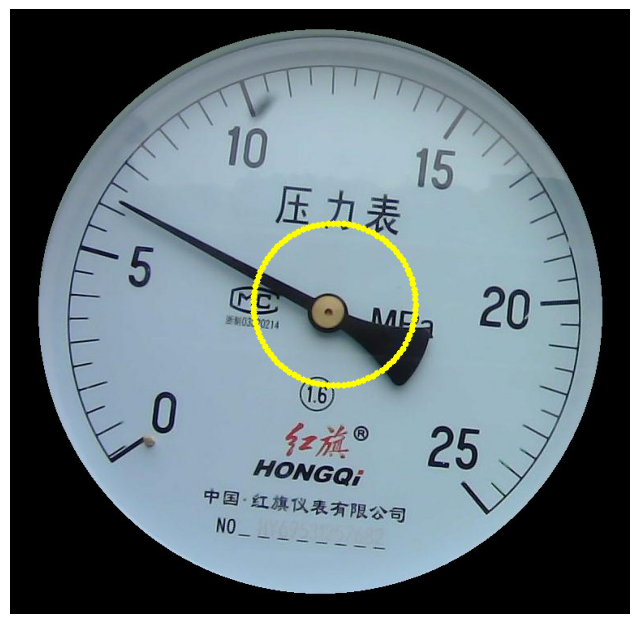

In [83]:
# debug

# theta_res = np.linspace(0, 2*np.pi, 100)  # Angle values
# x_res, y_res = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)
# # 预览 检查椭圆曲线拟合
# show_point(image, x_res, y_res)

theta_res = np.linspace(0, 2*np.pi, 100)  # Angle values
x_res, y_res = get_Point_in_ellipse(400, 400, 100, 10, 0, theta_res)
# 预览 检查椭圆曲线拟合
show_point(image, x_res, y_res)


# 这里只显示椭圆形状 点准不准没有意义

根据zone_point绘制扫描区域

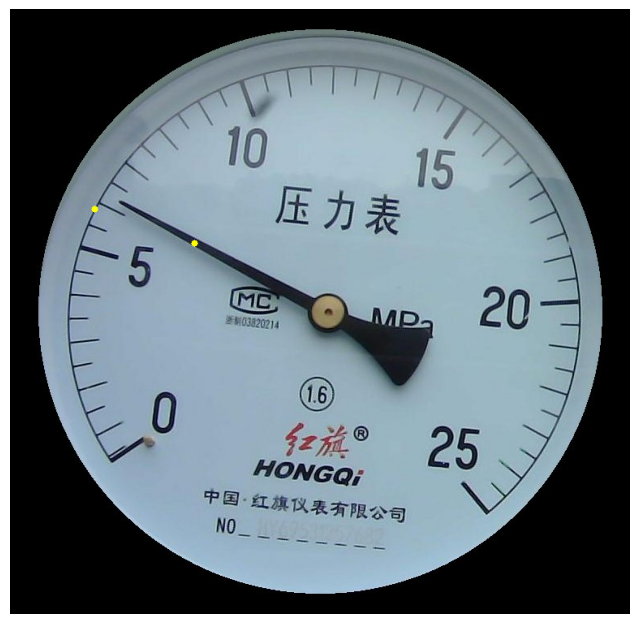

In [47]:
zone_point_x = zone_point[0]
zone_point_y = image.shape[1] - zone_point[1]

# 求出方向向量上在椭圆的坐标点
theta_zone_point_in_ellipse = np.arctan2(zone_point_y - y0, zone_point_x - x0)
point_in_ellipse_x, point_in_ellipse_y = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_zone_point_in_ellipse)

show_point( image, [point_in_ellipse_x, zone_point_x], [point_in_ellipse_y, zone_point_y] )

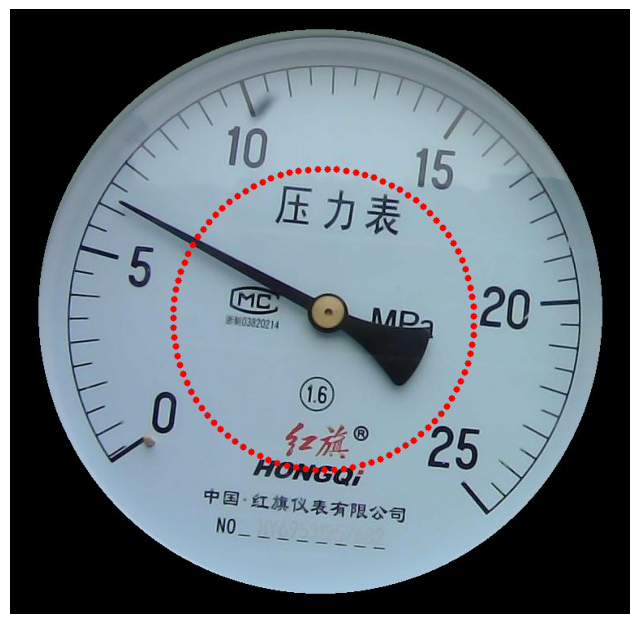

In [48]:
zone_vec1 = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0])
zone_vec2 = np.array([point_in_ellipse_x, point_in_ellipse_y]) - np.array([x0,y0])
s = np.linalg.norm(zone_vec1)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
a_zone = a_res * s
b_zone = b_res * s

# 扫描区域 中线的椭圆
theta_res = np.linspace(0, 2*np.pi, 100)  # Angle values
x_zone, y_zone = get_Point_in_ellipse(x0, y0, a_zone, b_zone, alpha_res, theta_res)
show_point(image, x_zone, y_zone, (0,0,255))

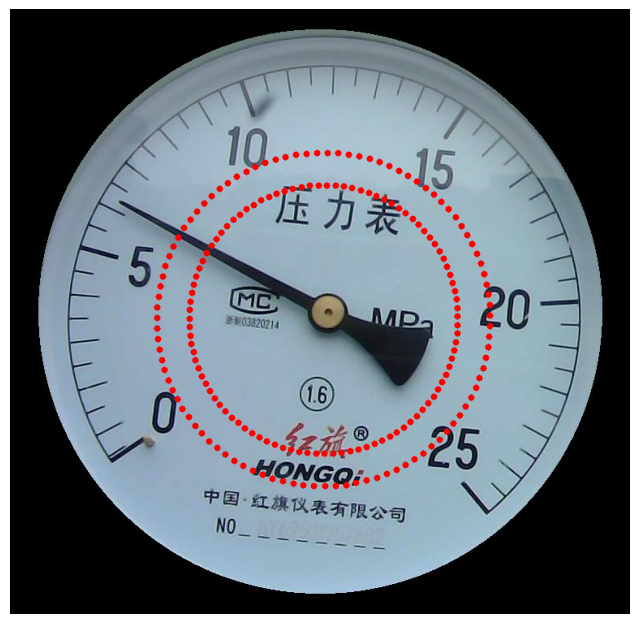

In [49]:
# 扫描区域可视化
s_l = (np.linalg.norm(zone_vec1)-zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
s_r = (np.linalg.norm(zone_vec1)+zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
x_zone_l, y_zone_l = get_Point_in_ellipse(x0, y0, a_res * s_l, b_res * s_l, alpha_res, theta_res)
x_zone_r, y_zone_r = get_Point_in_ellipse(x0, y0, a_res * s_r, b_res * s_r, alpha_res, theta_res)

show_point(image, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255))

## 计算刻度点坐标

In [50]:
# np.arctan2(y,x) 使用arctan2求弧度制夹角
# 第一象限 0 -> pi/2 （逆时针）
# 第二象限 pi/2 -> pi
# 第三象限 -pi -> -pi/2
# 第四象限 -pi/2 -> 0

# 刻度s到刻度t间 切分成separate_num份
# 返回左闭右开的点集序列
def separate_point(s_point, t_point, separate_num, keep_last_point=False):

    print('------------------------')
    print(s_point, t_point)

    s_point_x, s_point_y = s_point[0], s_point[1]
    t_point_x, t_point_y = t_point[0], t_point[1]

    # # 两个相邻标点不应该超过90度
    theta_s = np.arctan2(s_point_y - y0, s_point_x - x0)
    theta_t = np.arctan2(t_point_y - y0, t_point_x - x0)
    print(theta_s, theta_t)

    if theta_s < theta_t: theta_s += np.pi * 2 # 负角度

    # 切分出separate_num + 1个点
    theta_small_point = np.linspace(theta_s, theta_t, separate_num + 1)
    x_small, y_small = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_small_point)


    if not keep_last_point:
        x_small = x_small[:-1]
        y_small = y_small[:-1]
    # 预览
    return x_small, y_small

第一次求解需要求解较小的、未标注出来的刻度点

定义x_samples、y_samples是从起点刻度到终点刻度，按顺时针方向排序的大刻度集合

若效果一般 应该标注所有刻度点（大小都标）并且跳过第一次求解

In [51]:
samples_num = len(x_samples)
x_samples_sep1, y_samples_sep1 = [], []

for i in range(1, samples_num):

    s_point = (x_samples[i - 1], y_samples[i - 1])
    t_point = (x_samples[i], y_samples[i])
    print(s_point, t_point)

    x_res, y_res = separate_point(s_point, t_point, step, i == samples_num - 1 )
    x_samples_sep1.extend( x_res )
    y_samples_sep1.extend( y_res )

    break

x_samples_sep1 = np.array(x_samples_sep1)
y_samples_sep1 = np.array(y_samples_sep1)

(121, 213) (77, 323)
------------------------
(121, 213) (77, 323)
-2.576202209622041 -2.9548361912084253


0.08639841493873987


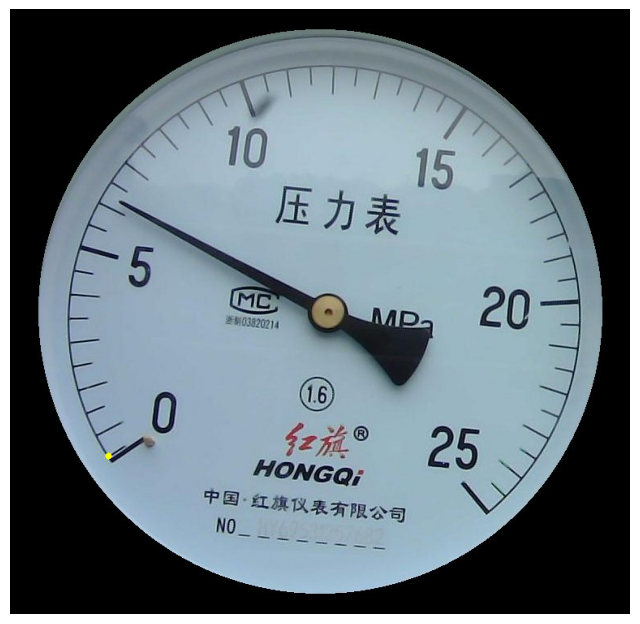

In [65]:
# debug
print(alpha_res)
x_debug, y_debug = get_Point_in_ellipse(x0, y0, a_res, b_res, 0, [-2.576202209622041])
show_point(image, x_debug, y_debug)

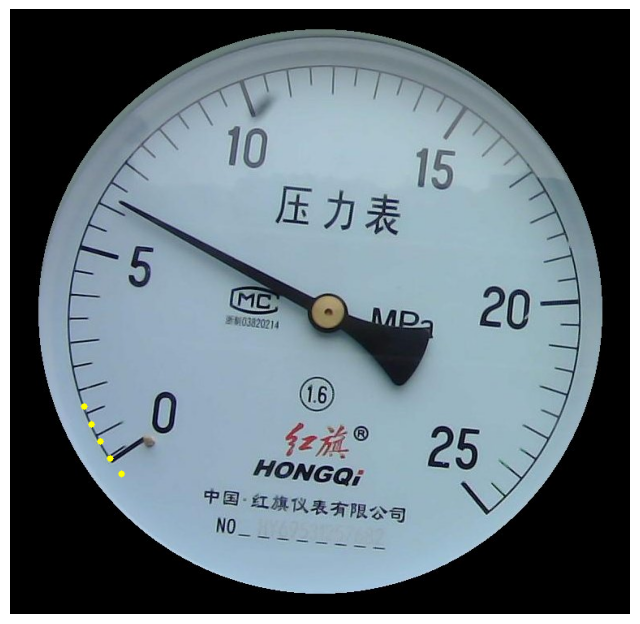

In [52]:
x_samples, y_samples = x_samples_sep1, y_samples_sep1
show_point(image, x_samples, y_samples)

第二次求解需要求出估读部分的刻度点

一般默认把所有刻度点之间切分10份

由于后续读数算法的要求 我们需要在首尾各增加一个新刻度

保证每个需要进行读数的刻度前后都有10个刻度 用于计算切线


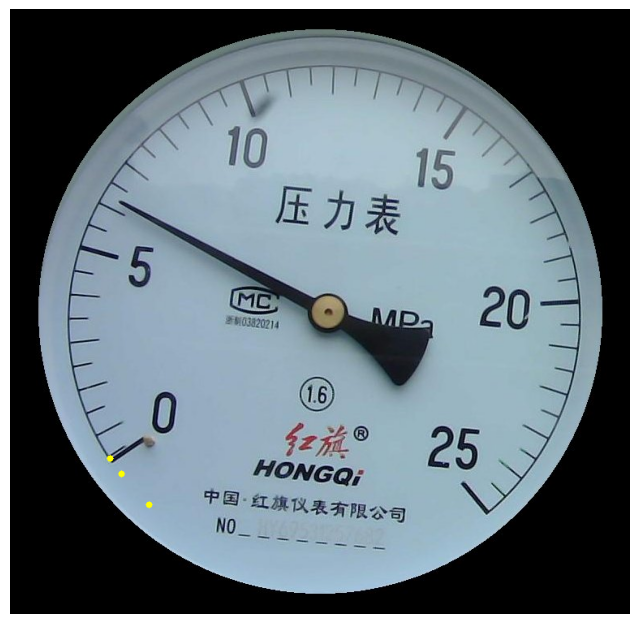

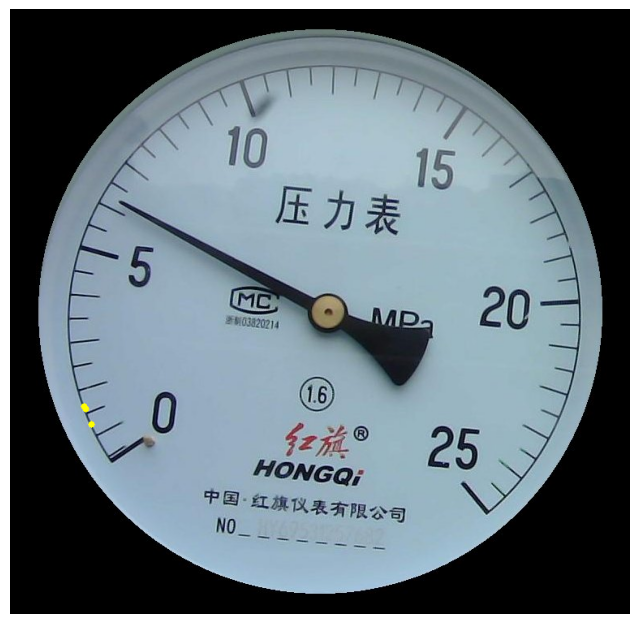

In [53]:
# 起点方向点
theta_s = np.arctan2(y_samples[0] - y0, x_samples[0] - x0) # 第一个点
theta_t = np.arctan2(y_samples[1] - y0, x_samples[1] - x0) # 第二个点
if theta_s < theta_t: theta_s += np.pi * 2 # 负角度
theta_newL = 2*theta_s - theta_t # theta_s是中点夹角

point_newx, point_newy = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, [theta_newL])
show_point( image, np.concatenate((point_newx,x_samples[:2])), np.concatenate((point_newy, y_samples[:2])))

## 添加到最前面
x_samples = np.concatenate((point_newx, x_samples))
y_samples = np.concatenate((point_newy, y_samples))

# 终点方向点
theta_s = np.arctan2(y_samples[-2] - y0, x_samples[-2] - x0) # 倒数第二个点
theta_t = np.arctan2(y_samples[-1] - y0, x_samples[-1] - x0) # 倒数第一个点
if theta_s < theta_t: theta_s += np.pi * 2 # 负角度
theta_newL = 2*theta_t - theta_s # theta_t是中点夹角

point_newx, point_newy = get_Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, [theta_newL])
show_point( image, np.concatenate((point_newx, x_samples[-2:])),  np.concatenate((point_newy,y_samples[-2:])) )

## 添加到最后面
x_samples = np.concatenate((x_samples, point_newx))
y_samples = np.concatenate((y_samples, point_newy))

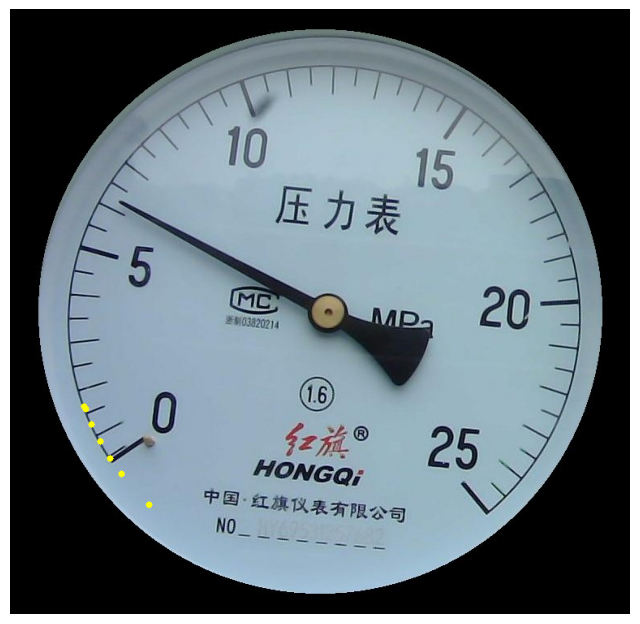

In [54]:
show_point(image, x_samples, y_samples)

In [55]:
# 切分估读区域
samples_num = len(x_samples)
x_samples_sep2, y_samples_sep2 = [], []

for i in range(1, samples_num):

    s_point = (x_samples[i - 1], y_samples[i - 1])
    t_point = (x_samples[i], y_samples[i])

    x_res, y_res = separate_point(s_point, t_point, 10, keep_last_point= (i == samples_num - 1))
    x_samples_sep2.extend( x_res )
    y_samples_sep2.extend( y_res )

x_samples_sep2 = np.array(x_samples_sep2)
y_samples_sep2 = np.array(y_samples_sep2)

------------------------
(171.27504490566687, 153.56638488537897) (137.3070399957179, 191.30585260336971)
-2.3276785834272844 -2.489803794683301
------------------------
(137.3070399957179, 191.30585260336971) (123.63279156847794, 210.70806020722597)
-2.489803794683301 -2.565530591000578
------------------------
(123.63279156847794, 210.70806020722597) (111.46559538530444, 231.08918056389874)
-2.565530591000578 -2.641257387317855
------------------------
(111.46559538530444, 231.08918056389874) (100.87519147599565, 252.33239300907059)
-2.641257387317855 -2.7169841836351316
------------------------
(100.87519147599565, 252.33239300907059) (91.92228200011988, 274.3159355322807)
-2.7169841836351316 -2.7927109799524086
------------------------
(91.92228200011988, 274.3159355322807) (93.08280184730413, 271.1778292132874)
-2.7927109799524086 -2.7820393613309458


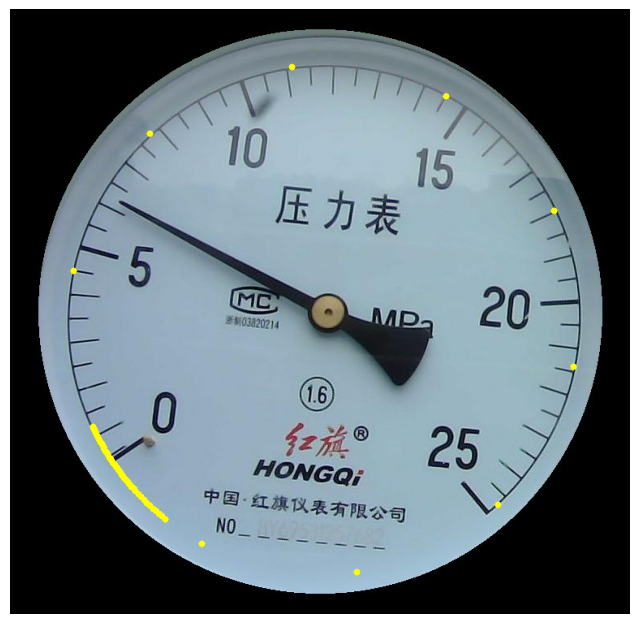

In [56]:
x_samples, y_samples = x_samples_sep2, y_samples_sep2
show_point(image, x_samples, y_samples)

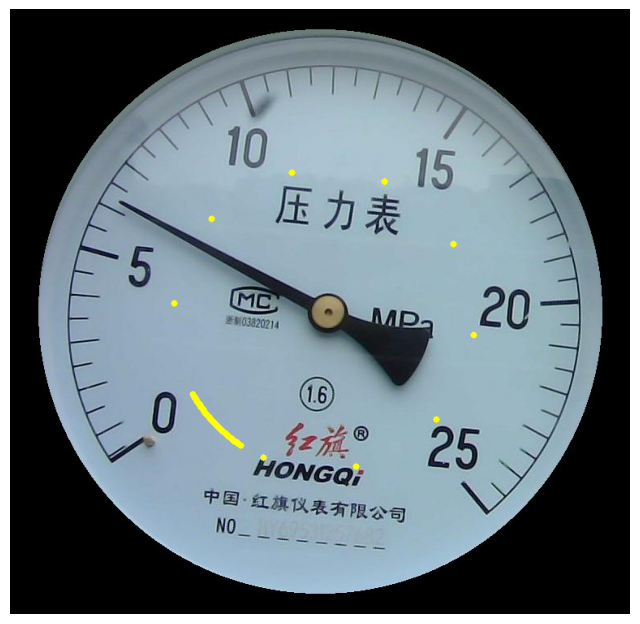

总共刻度点数 = 61


In [57]:
# 接下来把点集移动到扫描区域中线即可
theta_samples = [
    np.arctan2(y_samples[i] - y0, x_samples[i] - x0)
    for i in range(len(x_samples))
]
x_res, y_res = get_Point_in_ellipse(x0, y0, a_zone, b_zone, alpha_res, theta_samples)
show_point(image, x_res, y_res)
print(f'总共刻度点数 = {len(x_res)}')

# 转换回图片坐标
candidate_point = np.array([x_res, image.shape[1] - y_res]).T